<a href="https://colab.research.google.com/github/MVP-Willian/Ci-ncia_de_dados/blob/main/Ci%C3%AAncias%20de%20Dados/Notebooks/08%20-%20EDA%20com%20texto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise Exploratória de Dados Textuais

## Seção 1: Preparação do Ambiente e Carga dos Dados

### Introdução à Análise Exploratória de Dados para Textos

Antes de iniciar qualquer análise, é crucial definir um problema claro para guiar a exploração. Uma AED sem um objetivo pode se tornar um processo sem fim e com poucos resultados práticos. Para esta aula, nosso problema central será: **"O que as avaliações textuais dos clientes da Olist nos dizem sobre os principais motivos de satisfação e insatisfação?"**.

Para responder a essa pergunta, utilizaremos o **Dataset Olist**, um robusto conjunto de dados público que contém informações de 100.000 pedidos realizados em um grande marketplace brasileiro entre 2016 e 2018. Este dataset é particularmente valioso para Processamento de Linguagem Natural (PLN) por incluir uma rica coleção de avaliações de clientes, permitindo uma análise profunda da experiência de compra a partir de múltiplas dimensões, como status do pedido, pagamento, desempenho da entrega e atributos do produto.

### Configuração do Ambiente

Para iniciar nossa jornada, o primeiro passo é configurar o ambiente de desenvolvimento, importando as bibliotecas essenciais que nos darão as ferramentas necessárias para manipulação, processamento e visualização dos dados.

In [1]:
# Importação das bibliotecas fundamentais
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string

# Bibliotecas para Processamento de Linguagem Natural (PLN)
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.rslp import RSLPStemmer
from nltk.probability import FreqDist
from wordcloud import WordCloud

# Configurações de visualização
sns.set_style("whitegrid")
%matplotlib inline

# Download de recursos necessários do NLTK (executar apenas na primeira vez)
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('rslp')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


True

A biblioteca `nltk` (Natural Language Toolkit) é o pilar de nossas operações de PLN. O comando `nltk.download()` é utilizado para baixar pacotes de dados essenciais: `punkt` contém modelos pré-treinados para tokenização (divisão de texto em palavras), `stopwords` fornece listas de palavras comuns a serem filtradas, e `rslp` contém o algoritmo de *stemming* para a língua portuguesa.

### Carregamento e Inspeção Inicial dos Dados

Com o ambiente configurado, o próximo passo é carregar o arquivo que contém as avaliações dos clientes, `olist_order_reviews_dataset.csv`, e realizar uma inspeção inicial para entender sua estrutura e qualidade.

In [ ]:
# Carregando o dataset de avaliações
reviews_df = pd.read_csv('../data/olist_order_reviews_dataset.csv')

# Exibindo as primeiras linhas do DataFrame
print("Amostra dos dados:")
display(reviews_df.head())

# Exibindo informações gerais sobre o DataFrame
print("\nInformações do DataFrame:")
reviews_df.info()

# Verificando a quantidade de valores nulos em cada coluna
print("\nContagem de valores nulos por coluna:")
print(reviews_df.isnull().sum())

FileNotFoundError: [Errno 2] No such file or directory: '../data/olist_order_reviews_dataset.csv'

A inspeção inicial revela informações cruciais. O método `.info()` nos mostra os tipos de dados de cada coluna e o uso de memória, enquanto `.isnull().sum()` quantifica os dados ausentes. Para facilitar a compreensão, a tabela a seguir detalha o significado de cada coluna.

**Tabela 1: Dicionário de Dados do `olist_order_reviews_dataset.csv`**

| Nome da Coluna | Descrição |
| :--- | :--- |
| `review_id` | Identificador único da avaliação. |
| `order_id` | Identificador único do pedido associado à avaliação. |
| `review_score` | Nota atribuída pelo cliente (escala de 1 a 5). |
| `review_comment_title` | Título do comentário da avaliação (opcional). |
| `review_comment_message` | Corpo do comentário da avaliação (opcional). |
| `review_creation_date` | Data em que a pesquisa de satisfação foi enviada ao cliente. |
| `review_answer_timestamp` | Data e hora em que o cliente respondeu à pesquisa. |

A análise de valores nulos destaca um ponto de atenção: as colunas `review_comment_title` e `review_comment_message` possuem uma quantidade expressiva de dados ausentes. Isso é esperado, pois muitos clientes atribuem uma nota sem deixar um comentário escrito. Nossa estratégia será unificar essas duas colunas em um único campo de texto, `review_text`. Para as entradas nulas, utilizaremos o método `.fillna("")` para substituí-las por uma string vazia, garantindo que as operações de texto subsequentes não resultem em erros.

In [ ]:
# Combinando título e mensagem em uma única coluna de texto
# Preenchendo valores nulos com strings vazias para evitar erros
reviews_df['review_text'] = reviews_df['review_comment_title'].fillna('') + ' ' + reviews_df['review_comment_message'].fillna('')

# Removendo as colunas originais e mantendo apenas a nova coluna de texto e as demais
reviews_df = reviews_df.drop(columns=['review_comment_title', 'review_comment_message'])

# Verificando as primeiras linhas com a nova coluna
display(reviews_df.head())

,review_id,order_id,review_score,review_creation_date,review_answer_timestamp,review_text
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,2018-01-18 00:00:00,2018-01-18 21:46:59,
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,2018-03-10 00:00:00,2018-03-11 03:05:13,
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,2018-02-17 00:00:00,2018-02-18 14:36:24,
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,2017-04-21 00:00:00,2017-04-21 22:02:06,Recebi bem antes do prazo estipulado.
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,2018-03-01 00:00:00,2018-03-02 10:26:53,Parabéns lojas lannister adorei comprar pela ...


Este tratamento de dados nos deixa com um DataFrame mais limpo e uma única coluna de texto pronta para a análise. É importante notar que a alta taxa de comentários em branco introduz um viés inerente ao nosso corpus textual. A ação de dar uma nota (de 1 a 5) é uma tarefa de baixo esforço, enquanto escrever um comentário detalhado exige um esforço consideravelmente maior. Consequentemente, os clientes que investem tempo para escrever tendem a estar nos extremos do espectro de satisfação: ou muito satisfeitos, querendo elogiar, ou muito insatisfeitos, buscando detalhar um problema. As experiências medianas, que não geram uma forte reação emocional, são sub-representadas no texto. Portanto, as conclusões que extrairmos refletirão os "pontos de dor" e os "pontos de encanto" mais significativos da jornada do cliente, e não necessariamente os problemas mais frequentes, mas menos impactantes.

---

## Seção 2: Análise Descritiva e Limpeza Inicial do Texto

Após a preparação inicial, o próximo passo é mergulhar na análise descritiva do texto. Isso envolve quantificar características básicas das avaliações, como seu comprimento, e realizar os primeiros passos de limpeza para padronizar o corpus.

### Análise do Comprimento das Avaliações

Uma forma simples, porém poderosa, de começar a entender o texto é analisar seu comprimento. Avaliações muito curtas podem ser genéricas, enquanto avaliações longas podem conter detalhes ricos sobre a experiência do cliente. Vamos criar duas novas colunas: `review_length`, com o número de caracteres, e `word_count`, com o número de palavras de cada avaliação.

In [ ]:
# Criando uma coluna para o número de caracteres
reviews_df['review_length'] = reviews_df['review_text'].str.len()

# Criando uma coluna para o número de palavras
reviews_df['word_count'] = reviews_df['review_text'].apply(lambda x: len(x.split()))

# Exibindo estatísticas descritivas para as novas colunas
print("Estatísticas Descritivas do Comprimento das Avaliações:")
display(reviews_df[['review_length', 'word_count']].describe())

Estatísticas Descritivas do Comprimento das Avaliações:


,review_length,word_count
count,99224.000000,99224.000000
mean,30.738229,5.041462
std,49.673819,8.604777
min,1.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,0.000000
75%,46.000000,7.000000
max,229.000000,48.000000


Para visualizar a distribuição desses valores, um histograma é a ferramenta ideal. Utilizaremos a função `histplot` da biblioteca Seaborn.

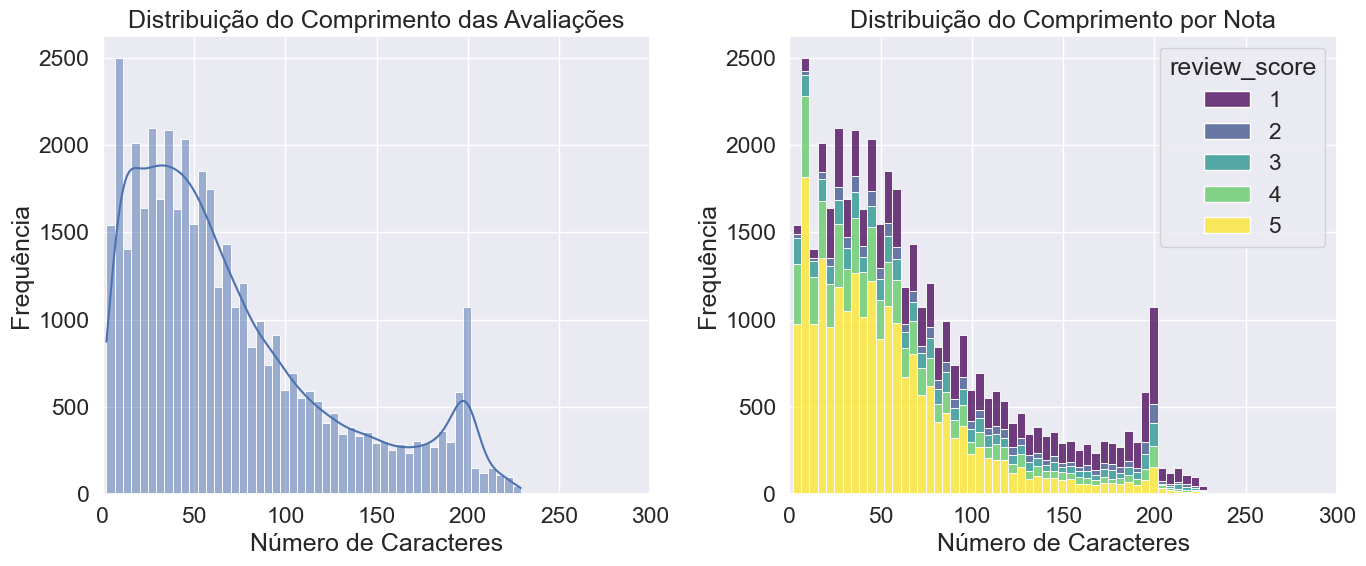

In [ ]:
# Visualização 1: Distribuição do Comprimento das Avaliações (em caracteres)

#tirar os valores com 0 e 1 da coluna review_length


plt.figure(figsize=(14, 6))
sns.set(font_scale=1.5)

# Histograma para todas as avaliações
plt.subplot(1, 2, 1)
sns.histplot(reviews_df[reviews_df['review_length'] > 1]['review_length'], bins=50, kde=True)
plt.title('Distribuição do Comprimento das Avaliações')
plt.xlabel('Número de Caracteres')
plt.ylabel('Frequência')
plt.xlim(0, 300) # Limitando o eixo x para melhor visualização

# Histograma do comprimento por nota de avaliação
plt.subplot(1, 2, 2)

sns.histplot(data=reviews_df[reviews_df['review_length'] > 1], x='review_length', hue='review_score', palette='viridis', multiple='stack', bins=50)
plt.title('Distribuição do Comprimento por Nota')
plt.xlabel('Número de Caracteres')
plt.ylabel('Frequência')
plt.xlim(0, 300)

plt.tight_layout()
plt.show()

A análise visual dos histogramas pode revelar um padrão interessante. Frequentemente, avaliações com notas muito baixas (1 ou 2) tendem a ser mais longas. Isso ocorre porque clientes insatisfeitos geralmente precisam de mais palavras para articular a natureza específica de seus problemas — seja um atraso na entrega, um produto com defeito ou uma experiência de atendimento ruim. Por outro lado, clientes satisfeitos podem expressar seu contentamento de forma mais concisa, com frases como "ótimo produto" ou "chegou rápido". Essa observação é valiosa, pois sugere que o comprimento do texto, por si só, pode funcionar como um indicador da intensidade do sentimento. Em um projeto de machine learning futuro, `review_length` e `word_count` poderiam ser utilizadas como *features* preditivas para classificar o sentimento de uma avaliação.

### Pré-processamento Básico do Texto

Antes de avançarmos para técnicas mais sofisticadas, é fundamental realizar uma limpeza básica para normalizar o texto. Este processo garante que variações irrelevantes, como o uso de maiúsculas e minúsculas ou a presença de pontuação, não interfiram na nossa análise.

#### Conversão para Minúsculas (Lowercase)

A conversão de todo o texto para letras minúsculas é um passo crucial de normalização. Para um computador, "Produto", "produto" e "PRODUTO" são três palavras distintas. Ao padronizá-las para "produto", garantimos que todas as ocorrências sejam contadas juntas, o que nos dá uma medida mais precisa da frequência e importância dos termos.

In [ ]:
# Criando uma nova coluna com o texto limpo, começando pela conversão para minúsculas
reviews_df['clean_text'] = reviews_df['review_text'].str.lower()

#### Remoção de Pontuação

Caracteres de pontuação como vírgulas, pontos e pontos de exclamação são essenciais para a estrutura gramatical e a legibilidade humana, mas geralmente adicionam ruído à análise de frequência de palavras. A remoção desses caracteres nos ajuda a focar no conteúdo semântico do texto. A abordagem mais robusta para essa tarefa é o uso de expressões regulares (regex), que permitem definir um padrão para encontrar e substituir todos os caracteres que não são letras, números ou espaços em branco.

In [ ]:
# Removendo pontuação usando expressões regulares
# O padrão [^\w\s] corresponde a qualquer caractere que não seja uma letra/número (\w) ou um espaço em branco (\s)
reviews_df['clean_text'] = reviews_df['clean_text'].str.replace(r'[^\w\s]', ' ', regex=True)

# Exibindo o texto original e o texto limpo para comparação
print("Comparação do Texto Original vs. Limpo:")
display(reviews_df[['review_text', 'clean_text']].sample(5))

Comparação do Texto Original vs. Limpo:


,review_text,clean_text
87209,,
31888,,
63029,O suporte poderia ser melhor e ter marcação p...,o suporte poderia ser melhor e ter marcação p...
81831,Excelente Excelente,excelente excelente
21322,"Produto dentro do esperad Adorei o canguru, co...",produto dentro do esperad adorei o canguru co...


Com esses dois passos, nosso texto está mais padronizado e pronto para as etapas de tokenização e análise de frequência.

---

## Seção 3: Tokenização e Remoção de Stopwords

Agora que nosso texto está limpo e padronizado, podemos avançar para duas etapas fundamentais do pré-processamento em PLN: a tokenização e a remoção de *stopwords*. Esses processos nos permitem decompor o texto em suas unidades básicas e filtrar o ruído para focar nos termos que realmente carregam significado.

### Tokenização

Tokenização é o processo de segmentar uma sequência de texto em unidades menores, chamadas de *tokens*. Na maioria dos casos, esses tokens são palavras individuais, mas também podem ser sentenças ou mesmo caracteres, dependendo da aplicação. Para a nossa análise de frequência, estamos interessados em tokens no nível de palavras. A biblioteca NLTK oferece a função `word_tokenize`, um tokenizador sofisticado que lida bem com contrações e outras nuances da linguagem.

In [ ]:
# Aplicando a tokenização na coluna de texto limpo
# O resultado será uma nova coluna onde cada linha contém uma lista de tokens (palavras)
reviews_df['tokens'] = reviews_df['clean_text'].apply(word_tokenize)
reviews_df['tokens_5'] = reviews_df[reviews_df['review_score'] == 5]['tokens']
reviews_df['tokens_1'] = reviews_df[reviews_df['review_score'] == 1]['tokens']


# Exibindo a nova coluna de tokens
print("Amostra da coluna de tokens:")
display(reviews_df[['clean_text', 'tokens']].head())

Amostra da coluna de tokens:


,clean_text,tokens
0,,[]
1,,[]
2,,[]
3,recebi bem antes do prazo estipulado,"[recebi, bem, antes, do, prazo, estipulado]"
4,parabéns lojas lannister adorei comprar pela ...,"[parabéns, lojas, lannister, adorei, comprar, ..."


### Remoção de Stopwords

*Stopwords* são palavras extremamente comuns em um idioma que, embora essenciais para a estrutura gramatical, carregam pouco ou nenhum valor semântico para a análise de conteúdo. Exemplos em português incluem "de", "a", "o", "que", "e", "do". A remoção dessas palavras nos ajuda a reduzir a dimensionalidade dos dados e a focar nos termos que realmente descrevem a experiência do cliente.

O NLTK fornece uma lista de stopwords para diversos idiomas, incluindo o português. Para otimizar o processo de verificação, é uma boa prática converter essa lista em um conjunto (`set`), pois a busca de elementos em um conjunto tem uma complexidade de tempo média de O(1), muito mais eficiente do que a busca em uma lista, que é O(n).

In [ ]:
# Carregando a lista de stopwords em português do NLTK
stop_words_pt = set(stopwords.words('portuguese'))

# Função para remover stopwords de uma lista de tokens
def remove_stopwords_func(tokens):
    return [word for word in tokens if word not in stop_words_pt]

# Aplicando a função para criar uma nova coluna com tokens limpos (sem stopwords)
reviews_df['tokens_no_stop'] = reviews_df['tokens'].apply(remove_stopwords_func)
reviews_df['tokens_no_stop_5'] = reviews_df[reviews_df['review_score'] == 5]['tokens_no_stop']
reviews_df['tokens_no_stop_1'] = reviews_df[reviews_df['review_score'] == 1]['tokens_no_stop']

# Exibindo o resultado da remoção de stopwords
print("Comparação de Tokens com e sem Stopwords:")
display(reviews_df[['tokens', 'tokens_no_stop']].head())

Comparação de Tokens com e sem Stopwords:


,tokens,tokens_no_stop
0,[],[]
1,[],[]
2,[],[]
3,"[recebi, bem, antes, do, prazo, estipulado]","[recebi, bem, antes, prazo, estipulado]"
4,"[parabéns, lojas, lannister, adorei, comprar, ...","[parabéns, lojas, lannister, adorei, comprar, ..."


Este processo de filtragem representa mais do que uma simples limpeza técnica; é uma transformação conceitual. Ao remover as *stopwords*, estamos efetivamente destilando o "sinal" semântico do "ruído" gramatical. As *stopwords* são a "cola" que une as palavras de conteúdo (substantivos, verbos, adjetivos) para formar sentenças compreensíveis para humanos. No entanto, para muitos algoritmos de PLN que se baseiam em frequência, elas obscurecem os termos que realmente importam. Ao isolar as palavras de conteúdo, transformamos a "linguagem humana" em "dados informacionais", preparando o terreno para uma análise de frequência muito mais significativa.

### Exercício Prático 3: Análise do Impacto das Stopwords

**Tarefa:** Calcule o número total de tokens em todo o corpus *antes* e *depois* da remoção de stopwords. Com base nesses números, calcule a porcentagem de redução de tokens. Por fim, identifique e liste as 10 stopwords que foram mais frequentemente removidas do dataset.

**Objetivo de Aprendizagem:** Este exercício tem como objetivo quantificar o impacto da remoção de stopwords no volume de dados e ajudar a entender quais são as palavras mais comuns e estruturais no contexto do português brasileiro utilizado em avaliações de e-commerce.

---

## Seção 4: Análise de Frequência com Unigrams e Bigrams

Com os tokens devidamente limpos, podemos agora realizar uma das análises mais fundamentais em texto: a análise de frequência. Vamos investigar quais são as palavras e frases mais comuns utilizadas pelos clientes, o que nos dará os primeiros insights sobre os principais tópicos de discussão.

### Análise de Unigrams (Palavras Individuais)

Um *unigram* é simplesmente uma palavra individual. Ao contar a frequência de cada unigram em nosso corpus, podemos identificar os termos mais recorrentes.

Primeiro, precisamos agrupar todos os nossos tokens (sem stopwords) em uma única lista. Em seguida, podemos usar a classe `FreqDist` do NLTK, que é otimizada para contar a frequência de itens em uma sequência.

As 20 palavras mais comuns (Unigrams):
[('produto', 19718), ('prazo', 8625), ('entrega', 7059), ('recomendo', 6407), ('bom', 5922), ('antes', 5691), ('chegou', 5679), ('recebi', 5562), ('entregue', 3953), ('veio', 3369), ('bem', 3137), ('qualidade', 2870), ('comprei', 2786), ('super', 2623), ('ótimo', 2543), ('loja', 2541), ('tudo', 2524), ('excelente', 2472), ('ainda', 2410), ('compra', 2356)]


/var/folders/jl/02kt03gj5n99h1czkswp582c0000gn/T/ipykernel_17070/1254260831.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=unigrams_df, x='Frequência', y='Palavra', palette='plasma')


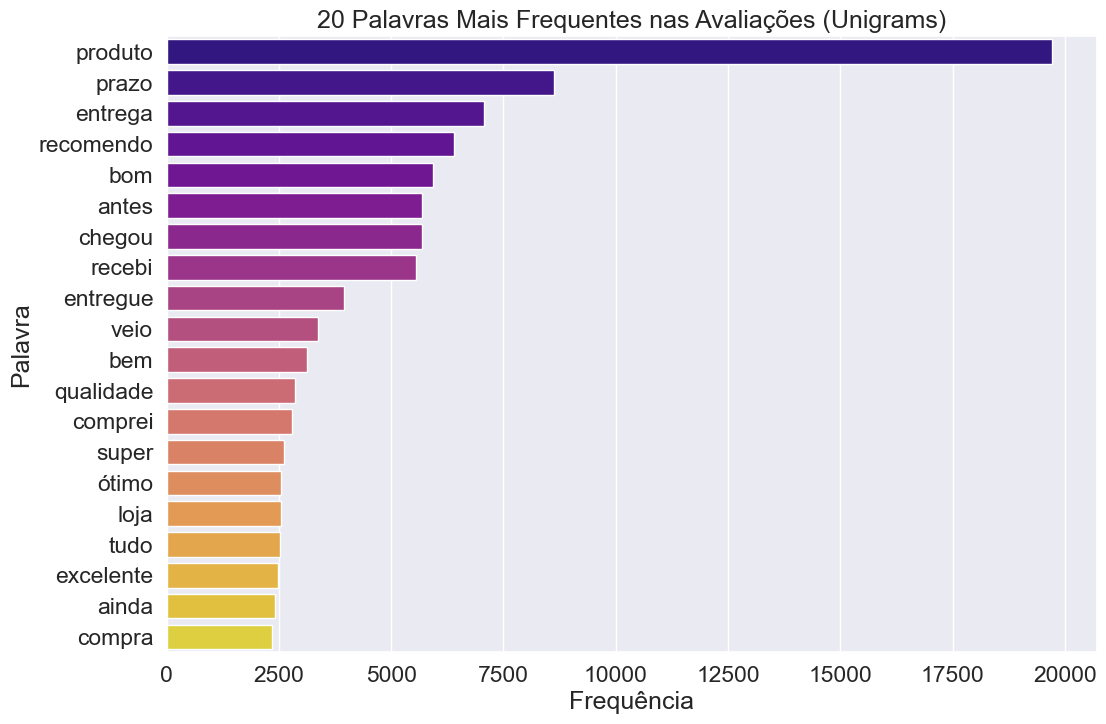

In [ ]:
# Criando uma lista única com todos os tokens (sem stopwords)
all_tokens = [token for sublist in reviews_df[to]['tokens_no_stop'] for token in sublist]

# Calculando a frequência de cada token
freq_dist = FreqDist(all_tokens)

# Exibindo as 20 palavras mais comuns
print("As 20 palavras mais comuns (Unigrams):")
print(freq_dist.most_common(20))

# Convertendo a distribuição de frequência para um DataFrame para facilitar a visualização
unigrams_df = pd.DataFrame(freq_dist.most_common(20), columns=['Palavra', 'Frequência'])

# Visualização 2: Gráfico de barras das palavras mais comuns
plt.figure(figsize=(12, 8))
sns.barplot(data=unigrams_df, x='Frequência', y='Palavra', palette='plasma')
plt.title('20 Palavras Mais Frequentes nas Avaliações (Unigrams)')
plt.xlabel('Frequência')
plt.ylabel('Palavra')
plt.show()

### Análise de Bigrams (Pares de Palavras)

Embora a análise de unigrams seja útil, ela perde o contexto. Por exemplo, as palavras "não" e "recebi" podem ser frequentes, mas a combinação "não recebi" é muito mais informativa. *N-grams* são sequências de *n* palavras consecutivas. Um *bigram* é um n-gram de tamanho 2. A análise de bigrams nos ajuda a capturar frases curtas e a entender melhor o contexto em que as palavras são usadas.

Os 20 bigrams mais comuns:
[(('antes', 'prazo'), 4244), (('recebi', 'produto'), 2026), (('produto', 'chegou'), 1785), (('produto', 'entregue'), 1708), (('chegou', 'antes'), 1527), (('super', 'recomendo'), 1284), (('produto', 'bom'), 1116), (('dentro', 'prazo'), 1087), (('entrega', 'rápida'), 990), (('bem', 'antes'), 975), (('bom', 'produto'), 930), (('recomendo', 'produto'), 905), (('ótimo', 'produto'), 856), (('produto', 'veio'), 801), (('prazo', 'entrega'), 772), (('entregue', 'antes'), 751), (('prazo', 'produto'), 729), (('bem', 'embalado'), 654), (('tudo', 'certo'), 595), (('entrega', 'antes'), 561)]


/var/folders/jl/02kt03gj5n99h1czkswp582c0000gn/T/ipykernel_17070/846098537.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bigrams_df, x='Frequência', y='Bigram', palette='magma')


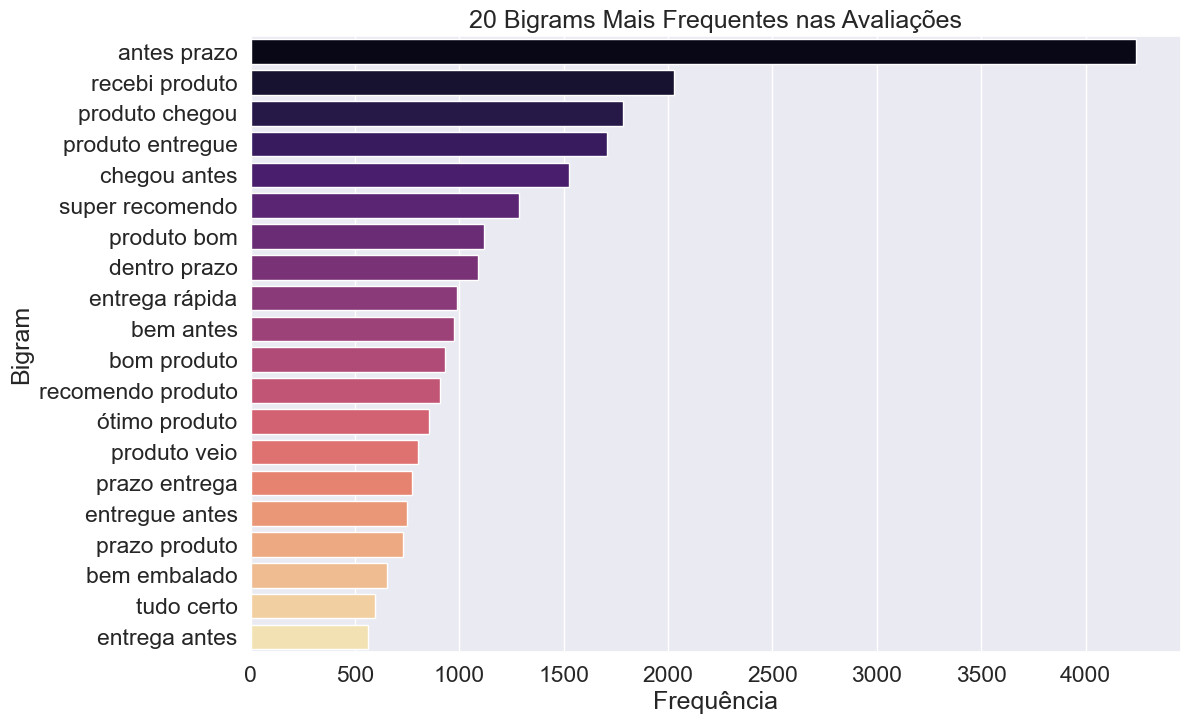

In [ ]:
# Gerando bigrams a partir da lista de todos os tokens
bigrams = list(nltk.bigrams(all_tokens))

# Calculando a frequência de cada bigram
freq_dist_bigrams = FreqDist(bigrams)

# Exibindo os 20 bigrams mais comuns
print("Os 20 bigrams mais comuns:")
print(freq_dist_bigrams.most_common(20))

# Formatando os bigrams para visualização
bigrams_list_for_df = freq_dist_bigrams.most_common(20)
bigrams_df = pd.DataFrame(bigrams_list_for_df, columns=['Bigram', 'Frequência'])
bigrams_df['Bigram'] = bigrams_df['Bigram'].apply(lambda x: ' '.join(x))

# Visualização: Gráfico de barras dos bigrams mais comuns
plt.figure(figsize=(12, 8))
sns.barplot(data=bigrams_df, x='Frequência', y='Bigram', palette='magma')
plt.title('20 Bigrams Mais Frequentes nas Avaliações')
plt.xlabel('Frequência')
plt.ylabel('Bigram')
plt.show()

A comparação entre os resultados de unigrams e bigrams revela uma camada mais profunda de insight. Enquanto os unigrams identificam os *sujeitos* da conversa (ex: "produto", "entrega", "prazo"), os bigrams frequentemente combinam esses sujeitos com um qualificador (adjetivo) ou uma ação (verbo), revelando a *natureza* da conversa. Por exemplo, "entrega" é um tópico, mas "entrega rápida" é um feedback positivo específico, e "produto errado" é um feedback negativo específico. A análise de bigrams é, portanto, um passo crucial para evoluir da identificação de "o quê" para a compreensão de "como", fornecendo insights muito mais acionáveis para a empresa. Se "antes prazo" é um bigrama comum em avaliações positivas, a eficiência logística é um ponto forte a ser mantido e destacado.

### Exercício Prático 4: Análise por nota

**Tarefa:** Repita o processo de análise de frequência para unigramas, bigramas e trigramas, mas com duas análises em separado, uma para as reviews como nota 1 e com nota 5

Para trigramas use nltk.trigrams()

In [ ]:
# Criando uma lista única com todos os tokens (sem stopwords)
all_tokens_5 = [token for sublist in reviews_df[reviews_df['review_score'] == 5]['tokens_no_stop'] for token in sublist]
all_tokens_1 = [token for sublist in reviews_df[reviews_df['review_score'] == 1]['tokens_no_stop'] for token in sublist]


# Calculando a frequência de cada token
freq_dist_5 = FreqDist(all_tokens_5)
freq_dist_1 = FreqDist(all_tokens_1)


# Código dos bigramas de notas 5

Os 20 bigrams mais comuns:
[(('antes', 'prazo'), 3490), (('chegou', 'antes'), 1240), (('super', 'recomendo'), 1185), (('produto', 'chegou'), 1073), (('produto', 'entregue'), 877), (('bem', 'antes'), 825), (('entrega', 'rápida'), 801), (('ótimo', 'produto'), 726), (('dentro', 'prazo'), 675), (('recomendo', 'produto'), 646), (('produto', 'bom'), 637), (('entregue', 'antes'), 620), (('bom', 'produto'), 554), (('bem', 'embalado'), 545), (('prazo', 'produto'), 539), (('entrega', 'antes'), 473), (('chegou', 'bem'), 453), (('ótima', 'qualidade'), 442), (('excelente', 'produto'), 436), (('produto', 'excelente'), 432)]


/var/folders/jl/02kt03gj5n99h1czkswp582c0000gn/T/ipykernel_17070/3038118168.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bigrams_df, x='Frequência', y='Bigram', palette='magma')


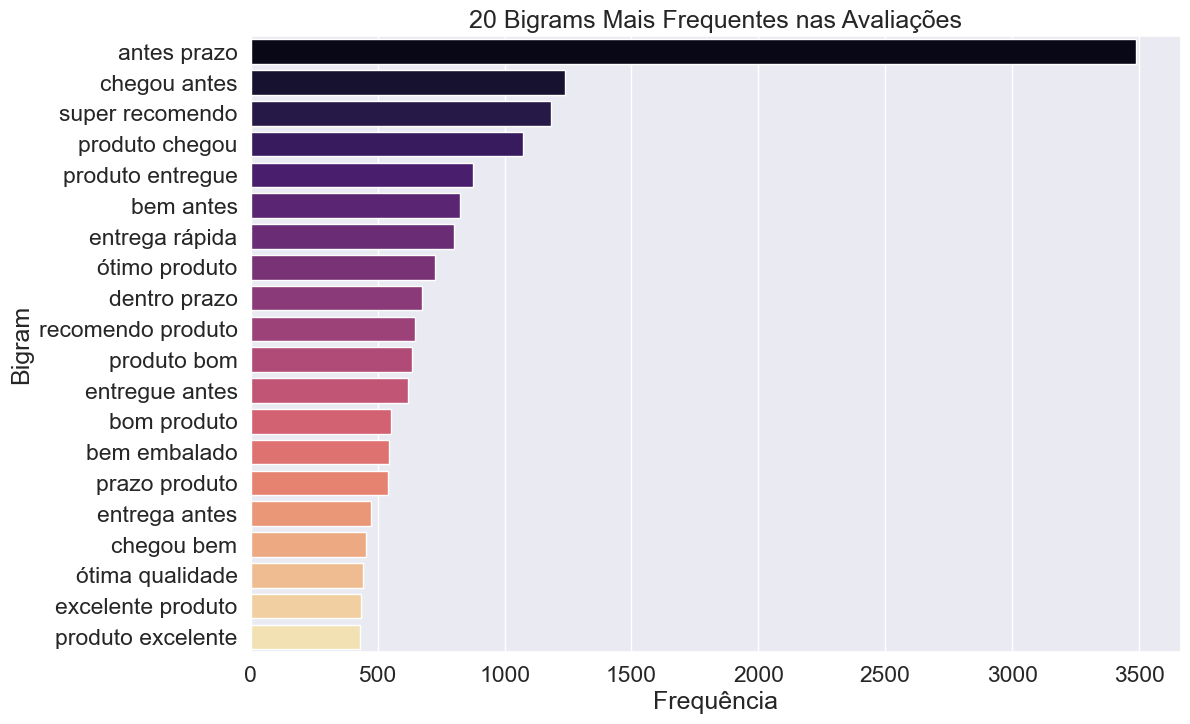

In [ ]:
# Gerando bigrams a partir da lista de todos os tokens
bigrams = list(nltk.bigrams(all_tokens_5))

# Calculando a frequência de cada bigram
freq_dist_bigrams = FreqDist(bigrams)

# Exibindo os 20 bigrams mais comuns
print("Os 20 bigrams mais comuns:")
print(freq_dist_bigrams.most_common(20))

# Formatando os bigrams para visualização
bigrams_list_for_df = freq_dist_bigrams.most_common(20)
bigrams_df = pd.DataFrame(bigrams_list_for_df, columns=['Bigram', 'Frequência'])
bigrams_df['Bigram'] = bigrams_df['Bigram'].apply(lambda x: ' '.join(x))

# Visualização: Gráfico de barras dos bigrams mais comuns
plt.figure(figsize=(12, 8))
sns.barplot(data=bigrams_df, x='Frequência', y='Bigram', palette='magma')
plt.title('20 Bigrams Mais Frequentes nas Avaliações')
plt.xlabel('Frequência')
plt.ylabel('Bigram')
plt.show()

# Código dos bigramas notas 1

Os 20 bigrams mais comuns:
[(('recebi', 'produto'), 1190), (('produto', 'entregue'), 430), (('ainda', 'recebi'), 344), (('produto', 'veio'), 306), (('produto', 'chegou'), 261), (('nao', 'recebi'), 235), (('produto', 'ainda'), 218), (('nota', 'fiscal'), 215), (('comprei', 'produto'), 200), (('prazo', 'entrega'), 199), (('recebi', 'apenas'), 169), (('produto', 'recebi'), 153), (('produto', 'comprei'), 150), (('comprei', 'dois'), 147), (('dinheiro', 'volta'), 147), (('comprei', '2'), 146), (('produto', 'errado'), 142), (('entrega', 'produto'), 136), (('produto', 'nao'), 116), (('produto', 'produto'), 114)]


/var/folders/jl/02kt03gj5n99h1czkswp582c0000gn/T/ipykernel_17070/3829260874.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bigrams_df, x='Frequência', y='Bigram', palette='magma')


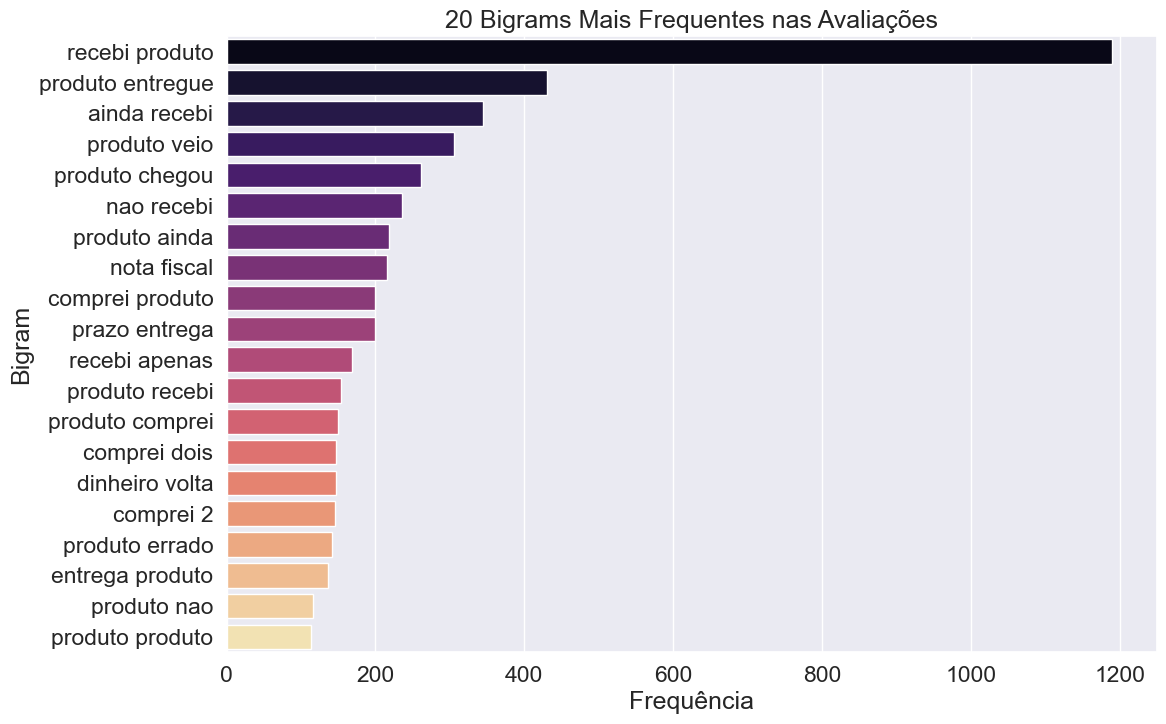

In [ ]:
# Gerando bigrams a partir da lista de todos os tokens
bigrams = list(nltk.bigrams(all_tokens_1))

# Calculando a frequência de cada bigram
freq_dist_bigrams = FreqDist(bigrams)

# Exibindo os 20 bigrams mais comuns
print("Os 20 bigrams mais comuns:")
print(freq_dist_bigrams.most_common(20))

# Formatando os bigrams para visualização
bigrams_list_for_df = freq_dist_bigrams.most_common(20)
bigrams_df = pd.DataFrame(bigrams_list_for_df, columns=['Bigram', 'Frequência'])
bigrams_df['Bigram'] = bigrams_df['Bigram'].apply(lambda x: ' '.join(x))

# Visualização: Gráfico de barras dos bigrams mais comuns
plt.figure(figsize=(12, 8))
sns.barplot(data=bigrams_df, x='Frequência', y='Bigram', palette='magma')
plt.title('20 Bigrams Mais Frequentes nas Avaliações')
plt.xlabel('Frequência')
plt.ylabel('Bigram')
plt.show()

---

## Seção 5: Visualização Intuitiva com Nuvens de Palavras

As nuvens de palavras (*word clouds*) são uma das formas mais populares e intuitivas de visualizar dados textuais. Elas representam a frequência de cada palavra através do tamanho de sua fonte: quanto mais frequente a palavra, maior ela aparece na nuvem. Essa técnica permite uma absorção rápida e visual dos termos mais proeminentes em um grande volume de texto.

### Geração de uma Nuvem de Palavras Geral

Para criar nossa primeira nuvem de palavras, precisamos concatenar todos os nossos tokens limpos (sem stopwords) em uma única e longa string. Em seguida, utilizaremos a biblioteca `wordcloud` para gerar e exibir a visualização.

In [ ]:
# Concatenando todos os tokens em uma única string
text_for_wordcloud = ' '.join(all_tokens)

# Criando o objeto WordCloud
# background_color='white' melhora a legibilidade
# collocations=False evita que a biblioteca agrupe bigrams automaticamente
wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(text_for_wordcloud)

# Exibindo a nuvem de palavras com Matplotlib
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') # Remove os eixos
plt.title('Nuvem de Palavras Geral das Avaliações de Clientes')
plt.show()

### Nuvens de Palavras Comparativas por Sentimento

Uma nuvem de palavras geral é útil, mas o verdadeiro poder dessa visualização emerge quando a usamos para comparar diferentes segmentos do nosso dataset. Vamos criar duas nuvens de palavras distintas: uma para as avaliações mais positivas (`review_score` = 5) e outra para as mais negativas (`review_score` = 1). Isso nos permitirá contrastar visualmente o vocabulário usado em cada cenário.

In [ ]:
# Filtrando o texto para avaliações positivas (nota 5)
positive_reviews_text = ' '.join([token for sublist in reviews_df[reviews_df['review_score'] == 5]['tokens_no_stop'] for token in sublist])

# Filtrando o texto para avaliações negativas (nota 1)
negative_reviews_text = ' '.join([token for sublist in reviews_df[reviews_df['review_score'] == 1]['tokens_no_stop'] for token in sublist])

# Gerando a nuvem de palavras para avaliações positivas
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(positive_reviews_text)

# Gerando a nuvem de palavras para avaliações negativas
wordcloud_negative = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(negative_reviews_text)

# Plotando as duas nuvens lado a lado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(wordcloud_positive, interpolation='bilinear')
ax1.set_title('Nuvem de Palavras - Avaliações Positivas (Nota 5)', fontsize=16)
ax1.axis('off')

ax2.imshow(wordcloud_negative, interpolation='bilinear')
ax2.set_title('Nuvem de Palavras - Avaliações Negativas (Nota 1)', fontsize=16)
ax2.axis('off')

plt.show()

A comparação visual entre as duas nuvens revela a dicotomia da experiência do cliente.

Essas duas nuvens podem funcionar como um "dicionário" visual de indicadores de desempenho operacional. Os termos na nuvem negativa são alertas diretos para áreas que necessitam de melhoria, como logística, controle de qualidade e atendimento ao cliente. Os termos na nuvem positiva representam os pontos fortes da operação, que podem e devem ser utilizados em estratégias de marketing para reforçar a proposta de valor da empresa.

### Exercício Prático 5: Análise das Avaliações Neutras

**Tarefa:** Gere uma nuvem de palavras para as avaliações consideradas "neutras" (`review_score` = 3). Em seguida, compare visualmente essa nova nuvem com as nuvens de avaliações positivas e negativas que acabamos de criar. Descreva em um parágrafo as principais diferenças e semelhanças que você observou.

**Objetivo de Aprendizagem:** Este exercício incentiva a investigação da ambiguidade das avaliações "neutras". O objetivo é entender se o vocabulário delas se assemelha mais ao positivo, ao negativo, ou se possui características distintas, talvez indicando uma experiência mista (ex: "o produto é bom, mas a entrega demorou").

---

## Seção 6: Normalização de Palavras com Stemming

Até agora, tratamos palavras como "entrega", "entregou" e "entregue" como tokens distintos. No entanto, todas elas se referem ao mesmo conceito fundamental. O *stemming* é uma técnica de normalização que reduz as palavras ao seu radical (ou *stem*), agrupando diferentes flexões de uma mesma palavra. Isso ajuda a consolidar as contagens de frequência e a reduzir a complexidade do nosso vocabulário.

### Conceito de Stemming

O objetivo do *stemming* é remover sufixos e prefixos para obter o radical da palavra. É importante notar que o *stem* resultante nem sempre é uma palavra lexicograficamente correta. Por exemplo, "entregar", "entregou" e "entregue" podem ser reduzidas ao radical "entreg". Para a língua portuguesa, a biblioteca NLTK oferece o `RSLPStemmer` (Removedor de os da Língua Portuguesa), um algoritmo baseado em regras e projetado especificamente para o nosso idioma.

### Aplicação do Stemming

Vamos aplicar o `RSLPStemmer` a cada um dos nossos tokens limpos para criar uma nova coluna com os radicais.

In [ ]:
# Instanciando o stemmer para português
stemmer = RSLPStemmer()

# Função para aplicar o stemming a uma lista de tokens
def stem_tokens(tokens):
    return [stemmer.stem(token) for token in tokens]

# Aplicando a função para criar uma nova coluna de tokens com stemming
reviews_df['tokens_stemmed'] = reviews_df['tokens_no_stop'].apply(stem_tokens)

# Exibindo o resultado do stemming
print("Comparação de Tokens sem Stopwords vs. Tokens com Stemming:")
display(reviews_df[['tokens_no_stop', 'tokens_stemmed']].head())

### Reavaliando a Frequência

Com os radicais em mãos, podemos repetir nossa análise de frequência. Espera-se que as contagens de conceitos-chave aumentem, pois agora estamos agregando todas as suas variações.

In [ ]:
#do uma lista única com todos os tokens com stemming
all_stemmed_tokens = [token for sublist in reviews_df['tokens_stemmed'] for token in sublist]

# Calculando a frequência de cada radical
freq_dist_stemmed = FreqDist(all_stemmed_tokens)

# Convertendo para DataFrame para visualização
stemmed_list_for_df = freq_dist_stemmed.most_common(20)
stemmed_df = pd.DataFrame(stemmed_list_for_df, columns=['Radical', 'Frequência'])
# Visualização 3: Gráfico de barras dos radicais mais comuns
plt.figure(figsize=(12, 8))
sns.barplot(data=stemmed_df, x='Frequência', y='Radical', palette='viridis')
plt.title('20 Radicais Mais Frequentes nas Avaliações (após Stemming)')
plt.xlabel('Frequência')
plt.ylabel('Radical')
plt.show()

A comparação deste gráfico com o gráfico de unigrams da Seção anterior da agregação semântica. A análise de unigrams trata "problema" e "problemas" como duas entidades distintas, diluindo a importância do conceito subjacente de "problema". Após o *stemming*, ambas as palavras são mapeadas para o radical "problem", e suas frequências são somadas. Isso nos fornece uma medida muito mais precisa da importância de um *conceito*, em vez de apenas uma *palavra*. Essa normalização é fundamental para algoritmos de modelagem de tópicos, como o Latent Dirichlet A) que veremos a seguir, pois eles operam com base na frequência de "termos" para identificar temas. O *stemming* é, portanto, um passo crucial para reduzir o ruído morfológico e fortalecer o sinal temático em nosso corpus.

Além de stemming, temos também lemmatização, onde as palavras são simplificadas porém para palavras que ainda são palavras básicas. Como ele utiliza outra biblioteca (Spacy), o mesmo será abordado em aulas futuras.

### Exercício Prático 6: Identificação de Grupos de Palavras

**Tarefa:** Escolha um dos 5 radicais mais comuns do seu resultado (por exemplo, "produt", "entreg", "praz"). a, volte ao seu corpus de tokens *antes* do *stemming* (`tokens_no_stop`) e encontre todas as palavras únicas que foram reduzidas a esse radical específico.

**Objetivo de Aprendizagem:** Este exercício visa solidificar a compreensão do que o *stemming* faz na prática, mostrando explicitamente como diferentes palavras (flexões verbais, plurais, etc.) são agrupadas sob um único radical, e como isso consolida a contagem de frequência de um conceito.

---

## Seção 7: Descoberta de Tópicos com Latent Dirichlet Acation (LDA)

Até agora, exploramos o texto através de contagens de frequência e visualizações. Agora, vamos utilizar uma técnica de aprendizado de máquina não supervisionado, o **Latent Dirichlet Allocation (LDA)**, para descobrir automaticamente os principais temas ou "tópicos" latentes que são discutidos no corpus de avaliações.

### Introdução ao Topic Modeling e LDA

*Topic Modeling* é uma classe de algoritmos estatísticos usados para descobrir as estruturas temáticas abstratas que ocorrem em uma coleção de documentos. O LDA é um dos algoritmos mais populares para essa tarefa. A premissa fundamental do LDA é que cada documento (no nosso caso, cada avaliação) é uma mistura de vários tópicos, e cada tópico é, por sua vez, uma distribuição de probabilidades sobre um conjunto de palavras. Por exemplo, um tópico sobre "Logística" teria uma alta probilidade de gerar palavras como "entrega", "prazo", "rápido" e "correios".

### Preparação dos Dados para o LDA

O LDA, como a maioria dos algoritmos de machine learning, não opera diretamente sobre texto. Ele requer uma representação numérica. A abordagem padrão é a **Bag-of-Words (BoW)**, que representa cada documento como um vetor de contagens de palavras. Para isso, utilizaremos o `CountVe da biblioteca Scikit-learn, que transforma nosso corpus de texto em uma matriz documento-termo, onde cada linha é uma avaliação e cada coluna é uma palavra única (termo) do nosso vocabulário.

### Construção e Treinamento do Modelo LDA

Com a matriz pronta, podemos construir e treinar nosso modelo LDA. Um hiperparâmetro crucial é o `n_components`, que define o número de tópicos que queremos que o algoritmo encontre. A escolha desse número é muit um processo iterativo, mas começaremos com 5 tópicos para ver se eles representam categorias distintas e interpretáveis.

In [ ]:
# Instanciando o modelo LDA
# n_components é o número de tópicos que queremos encontrar
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)

# Treinando o modelo com a matriz documento-termo
lda_model.fit(doc_term_matrix)

### Interpretação e Visualização dos Tópicos

O resultado do treinamento do LDA é um modelo que aprendeu a associação entre palavras e tópicos. Podemos inspecionar o atributo `components_` do modelo para descobrir quais palavras são mais importantes para cada tópico.

In [ ]:
# Função para exibir os tópicos e suas principais palavras
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Tópico {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

# Obtendo os nomes das palavras (features) do nosso vocabulário
feature_names = vectorizer.get_feature_names_out()
num_top_words = 10

# Exibindo os tópicos
display_topics(lda_model, feature_names, num_top_words)

A saída desta função nos apresenta os tópicos descobertos. Cada tópico é representado por uma lista de suas 10 palavras mais prováveis. A tarefa agora é humana: interpretar esses grupos de palavras e atribuir a eles um rótulo significativo.



Essa análise revela a estrutura oculta da experiência do cliente. Enquanto a análise de frequência nos diz quais palavras são importantes, o LDA nos mostra quais palavras importantes tendem a ser usadas *juntando as dimensões subjacentes do feedback. Agora, em vez de reagir a palavras isoladas, a empresa pode monitorar a prevalência desses tópicos ao longo do tempo. Um aumento súbito no tópico "Problemas com o Produto ou Pedido" é um sinal de alerta muito mais claro e estratégico do que um simples aumento na frequência da palavra "problema", permitindo uma análise de causa raiz mais eficaz.

### Exercício Prático 7: Hiperparâmetros do Modelo

**Tarefa:** Treine o modelo LDA novamente, mas desta vez alterando o número de tópicos (`n_components`). Tente primeiro com 3 tópicos e depois com 10. Compare os tópicos resultantes em cada caso. Discuta qual número de tópicos parece gerar os resultados mais coerentes e interpretáveis para este dataset.

**Objetivo de Aprendizagem:** Este exercício introduz a ideia de que modelos de machine learning possuem hiperparâmetros que precisam sos. Ele demonstra que a "melhor" escolha nem sempre é baseada em uma métrica de erro, mas muitas vezes na interpretabilidade e na utilidade prática dos resultados do modelo.

---

## Seção 8: Conclusão

### Sumário dos Insights

Nesta aula, realizamos uma jornada completa de Análise Exploratória de Dados textuais, partindo de avaliações brutas de clientes e chegando à descoberta de temas estruturados. As técnicas aplicadas nos permitiram extrair insights valiosos e formar uma visão abrangente sobre a experiência do cliente na plataforma Olist.


Cada técnica utilizada adicionou uma peça ao quebra-cabeça. A análise de frequência e as nuvens de palavras nos deram uma visão geral dos termos mais importantes. A análise de n-grams adicionou contexto. O *stemming* nos permitiu agregar conceitos. E, finalmente, o LDA revelou a estrutura temática subjacente que conecta todas essas palavras.